In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:

df = pd.read_csv("train (3).csv", encoding='utf-8-sig')


texts = df['text'].values


labels = df['labels'].apply(lambda x: list(map(int, x.split())))
labels = np.vstack(labels.values).astype(np.float32)
NUM_LABELS = labels.shape[1]
print("Пример текста:", texts[0][:100], "...")
print("Пример меток:", labels[0])
print("Размерность массива меток:", labels.shape)

Пример текста: 15 января
Детская развлекательная программа
15-00 бесплатно
❗️
@
cafeotdyh
Кафе "Отдых"
📍
Запись обя ...
Пример меток: [1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1.]
Размерность массива меток: (29568, 20)


In [7]:
vectorizer = TfidfVectorizer(max_features=20000)  # можно менять max_features
X = vectorizer.fit_transform(df['text']).toarray()
X_train, X_val, y_train, y_val = train_test_split(
    X, labels, test_size=0.1, random_state=42
)

In [8]:
class TfidfDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TfidfDataset(X_train, y_train)
val_dataset = TfidfDataset(X_val, y_val)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [9]:
class TfidfNN(nn.Module):
    def __init__(self, input_dim, num_labels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_labels)
        )

    def forward(self, x):
        return self.model(x)

model = TfidfNN(input_dim=X_train.shape[1], num_labels=NUM_LABELS).to(DEVICE)


In [10]:
EPOCHS = 20
EARLY_STOPPING_PATIENCE = 3
MODEL_SAVE_PATH = 'best_tfidf_nn.pt'

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
total_steps = len(train_loader) * EPOCHS

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-2,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    pct_start=0.1
)

def train_epoch(model, loader):
    model.train()
    epoch_loss = 0
    all_preds, all_labels = [], []

    for x_batch, y_batch in loader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        all_preds.append(torch.sigmoid(outputs).detach().cpu())
        all_labels.append(y_batch.detach().cpu())

    preds = torch.cat(all_preds)
    targets = torch.cat(all_labels)
    f1 = f1_score(targets, preds > 0.5, average='micro')
    return epoch_loss / len(loader), f1


def eval_model(model, loader):
    model.eval()
    eval_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            eval_loss += loss.item()
            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(y_batch.cpu())

    preds = torch.cat(all_preds)
    targets = torch.cat(all_labels)
    f1 = f1_score(targets, preds > 0.5, average='micro')
    return eval_loss / len(loader), f1


In [11]:
history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
best_f1 = 0
early_stop_counter = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    train_loss, train_f1 = train_epoch(model, train_loader)
    val_loss, val_f1 = eval_model(model, val_loader)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        early_stop_counter = 0
        print("Модель сохранена")
    else:
        early_stop_counter += 1
        if early_stop_counter >= EARLY_STOPPING_PATIENCE:
            print("Ранняя остановка")
            break



Epoch 1/20
Train Loss: 0.3500 | Val Loss: 0.2112 | Val F1: 0.9144
✅ Model saved.

Epoch 2/20
Train Loss: 0.1818 | Val Loss: 0.1924 | Val F1: 0.9230
✅ Model saved.

Epoch 3/20
Train Loss: 0.1157 | Val Loss: 0.2024 | Val F1: 0.9276
✅ Model saved.

Epoch 4/20
Train Loss: 0.0778 | Val Loss: 0.2294 | Val F1: 0.9274

Epoch 5/20
Train Loss: 0.0605 | Val Loss: 0.2468 | Val F1: 0.9284
✅ Model saved.

Epoch 6/20
Train Loss: 0.0489 | Val Loss: 0.2628 | Val F1: 0.9289
✅ Model saved.

Epoch 7/20
Train Loss: 0.0415 | Val Loss: 0.2696 | Val F1: 0.9301
✅ Model saved.

Epoch 8/20
Train Loss: 0.0356 | Val Loss: 0.2862 | Val F1: 0.9309
✅ Model saved.

Epoch 9/20
Train Loss: 0.0302 | Val Loss: 0.2901 | Val F1: 0.9316
✅ Model saved.

Epoch 10/20
Train Loss: 0.0259 | Val Loss: 0.2963 | Val F1: 0.9321
✅ Model saved.

Epoch 11/20
Train Loss: 0.0224 | Val Loss: 0.3034 | Val F1: 0.9324
✅ Model saved.

Epoch 12/20
Train Loss: 0.0192 | Val Loss: 0.3129 | Val F1: 0.9321

Epoch 13/20
Train Loss: 0.0170 | Val Loss:

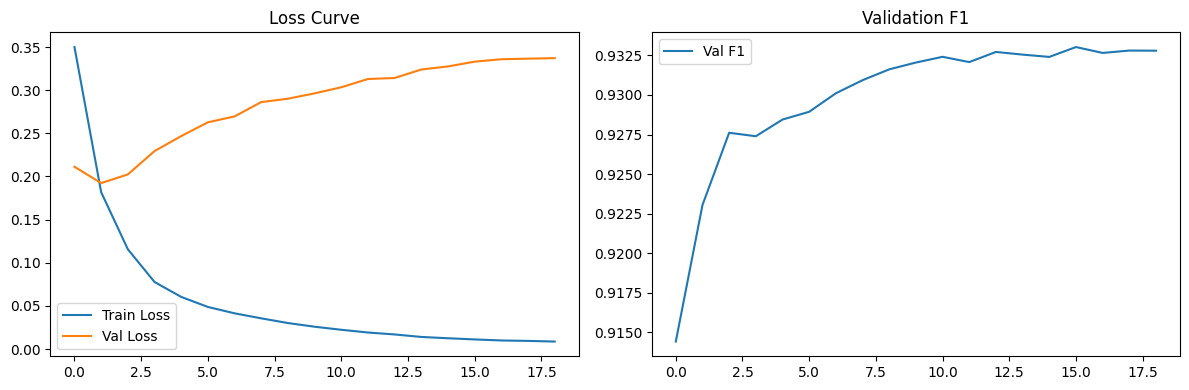

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_f1'], label='Val F1')
plt.title("Validation F1")
plt.legend()

plt.tight_layout()
plt.show()


In [6]:


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TfidfNN(nn.Module):
    def __init__(self, input_dim, num_labels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_labels)
        )

    def forward(self, x):
        return self.model(x)


df_test = pd.read_csv("test.csv", encoding='utf-8-sig')
test_texts = df_test['text'].values
test_ids = df_test['id'].values
df_train = pd.read_csv("train (3).csv", encoding='utf-8-sig')
train_texts = df_train['text'].values

vectorizer = TfidfVectorizer(max_features=20000)
vectorizer.fit(train_texts)

X_test = vectorizer.transform(test_texts).toarray()


labels = df_train['labels'].apply(lambda x: list(map(int, x.split())))
labels = np.vstack(labels.values).astype(np.float32)
NUM_LABELS = labels.shape[1]


model = TfidfNN(input_dim=X_test.shape[1], num_labels=NUM_LABELS).to(DEVICE)
model.load_state_dict(torch.load('best_tfidf_nn.pt', map_location=DEVICE))
model.eval()


class TfidfDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

test_dataset = TfidfDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

all_preds = []

with torch.no_grad():
    for x_batch in test_loader:
        x_batch = x_batch.to(DEVICE)
        outputs = model(x_batch)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.append(preds)

all_preds = np.vstack(all_preds)


all_preds_bin = (all_preds > 0.5).astype(int)


labels_str = [' '.join(map(str, row)) for row in all_preds_bin]

submission_df = pd.DataFrame({
    'id': test_ids,
    'labels': labels_str
})

submission_df.to_csv('submission.csv', index=False)
print("Предсказания сохранены в submission.csv")


Предсказания сохранены в submission.csv
